In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
import pylamp.utils.functions as fn
from pylamp.loss.losses import BCELoss,MSELoss, DiceLoss, CombinedDiceBCELoss
from matplotlib import pyplot as plt
from pylamp.neural.sequential import Sequential
from pylamp.neural.layers import Linear, Conv1D, MaxPool1D, Flatten, Upsampling1D
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import TanH, Sigmoid, ReLU
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps, show_usps
from pylamp.utils.plotter import Display

## Loading Data

In [46]:
uspsdatatrain = "./data/USPS/USPS_train.txt"
uspsdatatest = "./data/USPS/USPS_test.txt"
X_train, y_train = load_usps(uspsdatatrain)
X_test, y_test = load_usps(uspsdatatest)

In [47]:
# X_train, X_test = fn.normalize_data(X_train, X_test)

## Autoencoder on USPS data

• Encodage : Linear(256,100) → TanH() → Linear(100,10) → TanH()

• Décodage : Linear(10,100) → TanH() → Linear(100,256) → Sigmoide()

### One big Sequential

In [48]:
autoencoder_linear = Sequential()
autoencoder_linear.add_module(Linear(256,100))
autoencoder_linear.add_module(TanH())
autoencoder_linear.add_module(Linear(100,10))
autoencoder_linear.add_module(TanH())
autoencoder_linear.add_module(Linear(10,100))
autoencoder_linear.add_module(TanH())
autoencoder_linear.add_module(Linear(100,256))
autoencoder_linear.add_module(Sigmoid())


loss = CombinedDiceBCELoss()
optimizer_autoencoder = Optim(autoencoder_linear,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=64,epochs=300,verbose=True)

Epoch 1/300, Average Loss: 1.0775745095012677
Epoch 31/300, Average Loss: -0.956055462395946
Epoch 61/300, Average Loss: -1.4966988034333424
Epoch 91/300, Average Loss: -1.777697560077675
Epoch 121/300, Average Loss: -1.986725265447311
Epoch 151/300, Average Loss: -2.1565517907875287
Epoch 181/300, Average Loss: -2.2918139569860876
Epoch 211/300, Average Loss: -2.405218080136567
Epoch 241/300, Average Loss: -2.487208743299414
Epoch 271/300, Average Loss: -2.5515288924550044
Training finished.


Original VS AutoEncoder output:


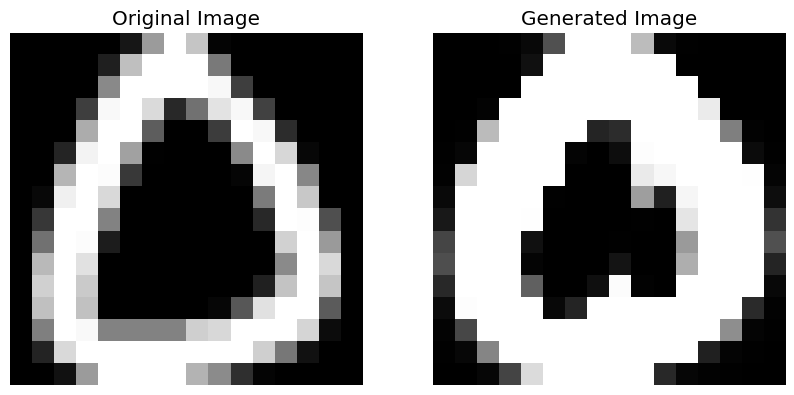

In [49]:
testing = np.array([X_test[100]])
testing_pred = autoencoder_linear.forward(testing)
print("Original VS AutoEncoder output:")
Display.compare_images(testing,testing_pred,shape=(16,16),fig_size=(10,5))

### Seperating encoder and decoder into two sequentials

In [22]:
# Define the autoencoder
autoencoder_conv = Sequential()

# Define the encoder
autoencoder_conv.add_module(Conv1D(kernel_size=3, in_channels=1, out_channels=32, strides=1, padding='same'))
autoencoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
autoencoder_conv.add_module(TanH())
autoencoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=16, strides=1, padding='same'))
autoencoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
autoencoder_conv.add_module(TanH())

# Define the decoder
autoencoder_conv.add_module(Upsampling1D(size=2))
autoencoder_conv.add_module(Conv1D(kernel_size=3, in_channels=16, out_channels=32, strides=1, padding='same'))
autoencoder_conv.add_module(TanH())
autoencoder_conv.add_module(Upsampling1D(size=2))
autoencoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=1, strides=1, padding='same'))
autoencoder_conv.add_module(Sigmoid())


# loss = BCELoss()
loss = DiceLoss()
optimizer_autoencoder_conv = Optim(autoencoder_conv,loss,1e-3)
autoencoder_losses_conv = SGD(optimizer_autoencoder, X_train, X_train, batch_size=64, epochs=20, add_channel_x=True, add_channel_y=True, verbose=True)

Epoch 1/20, Average Loss: 0.36874527276210445
Epoch 3/20, Average Loss: -0.30118728046624293
Epoch 5/20, Average Loss: -0.8242415174261223
Epoch 7/20, Average Loss: -1.4523841854507058
Epoch 9/20, Average Loss: -2.188350052049418
Epoch 11/20, Average Loss: -2.604809101716259
Epoch 13/20, Average Loss: -2.7788776777576794
Epoch 15/20, Average Loss: -2.852824361932296
Epoch 17/20, Average Loss: -2.8520735555956445
Epoch 19/20, Average Loss: -2.7279868525572533
Training finished.


Original VS AutoEncoder output:


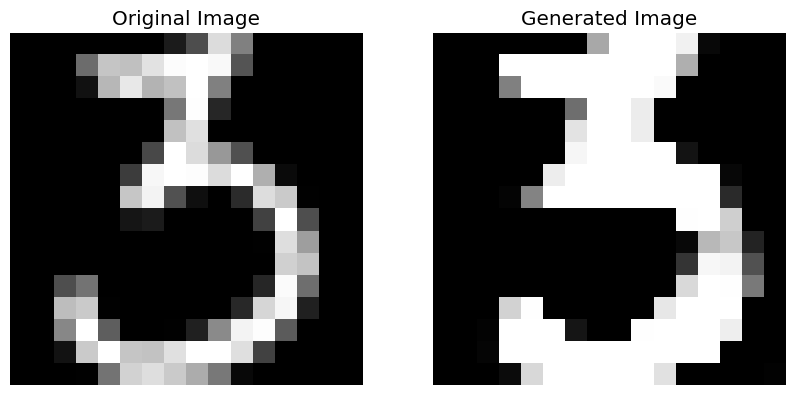

In [29]:
testing = np.expand_dims(np.expand_dims(X_test[500],-1),0)
decoded = autoencoder.forward(testing)
print("Original VS AutoEncoder output:")
Display.compare_images(testing,decoded,shape=(16,16),fig_size=(10,5))